In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import reciprocal
from reciprocal.kspace import KSpace
from reciprocal.canvas import Canvas
from reciprocal.lattice import LatticeVectors, Lattice
from reciprocal.kvector import KVectorGroup
from reciprocal.symmetry import Symmetry
from reciprocal.utils import apply_symmetry_operators
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.patches import Circle
import matplotlib.cm as cm

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['image.cmap']='plasma'



In [3]:
def get_lattice_vectors(shape):
    if shape == 'square':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 90.)
    elif shape == 'rectangle':
        return LatticeVectors.from_lengths_angle(np.pi*2*1.5, np.pi*2, 90.)
    elif shape == 'hexagon':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 60.)
    elif shape == 'oblique':
        return LatticeVectors.from_lengths_angle(np.pi*2, np.pi*2, 75.)
    
def get_symmetry(shape):
    if shape == 'square':
        return 'SIGMA_V'
    elif shape == 'rectangle':
        return 'D2'
    elif shape == 'hexagon':
        return 'D6'
    elif shape == 'oblique':
        return 'C2'

# Real Space Lattices

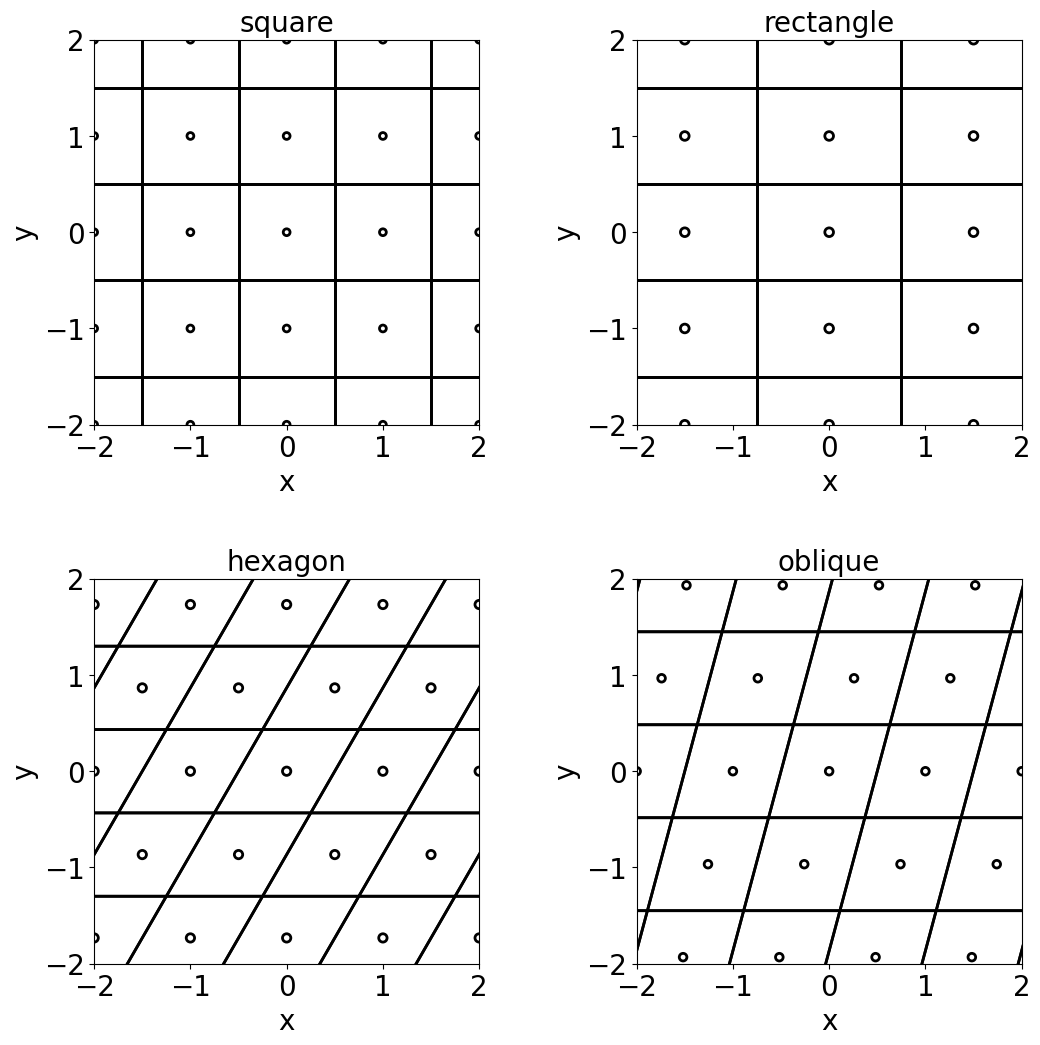

In [4]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    canvas.plot_tesselation(lat)
    canvas.plot_lattice(lat)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title(lat_shape, fontsize=20)    

AttributeError: 'UnitCell' object has no attribute 'weight_points'

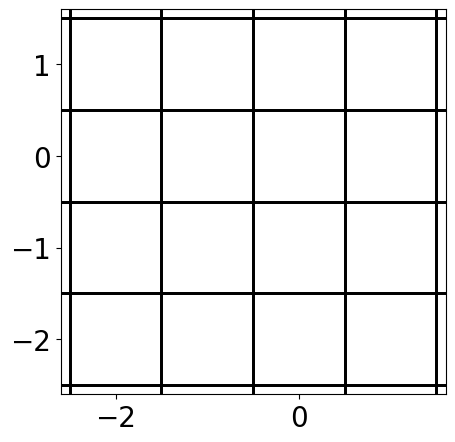

In [5]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    canvas.plot_tesselation(lat)
    #canvas.plot_lattice(lat)
    sampling, weighting = lat.unit_cell.sample(use_symmetry=False)
    canvas.plot_point_sampling(sampling)
    print(np.unique(weighting))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.title(lat_shape, fontsize=20)

# Reciprocal Lattices
## Irreducible Brillouin Zone & High Symmetry Points

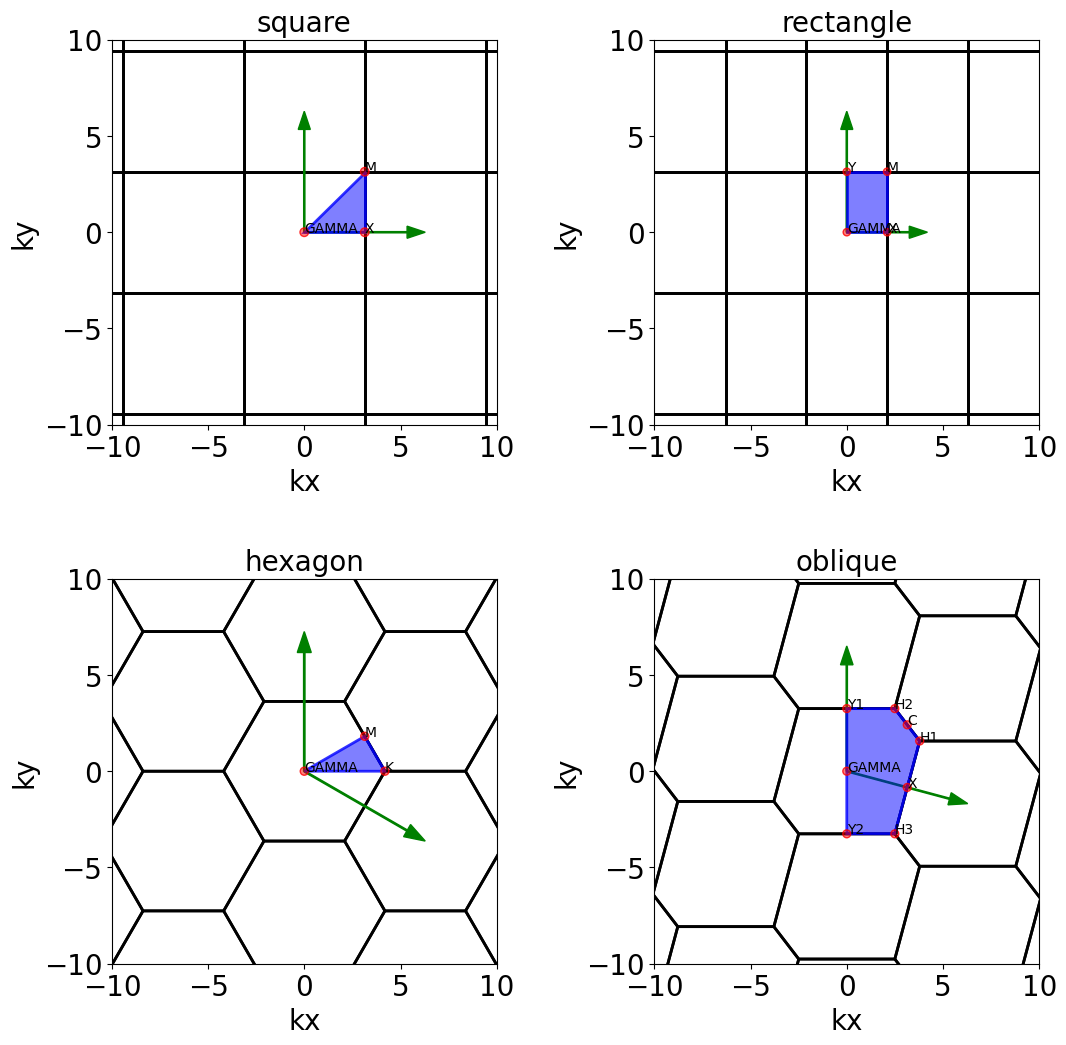

In [6]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)    
    canvas.plot_vectors(rlat)    
    canvas.plot_irreducible_uc(rlat.unit_cell)
    canvas.plot_special_points(rlat.unit_cell)
    

    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

## Weighted Sampling of the BZ

unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0
unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0000000000000002
unique weighting: [0.5 1. ]
integration value check: 0.9999999999999998
unique weighting: [0.5 1. ]
integration value check: 0.9999999999999998


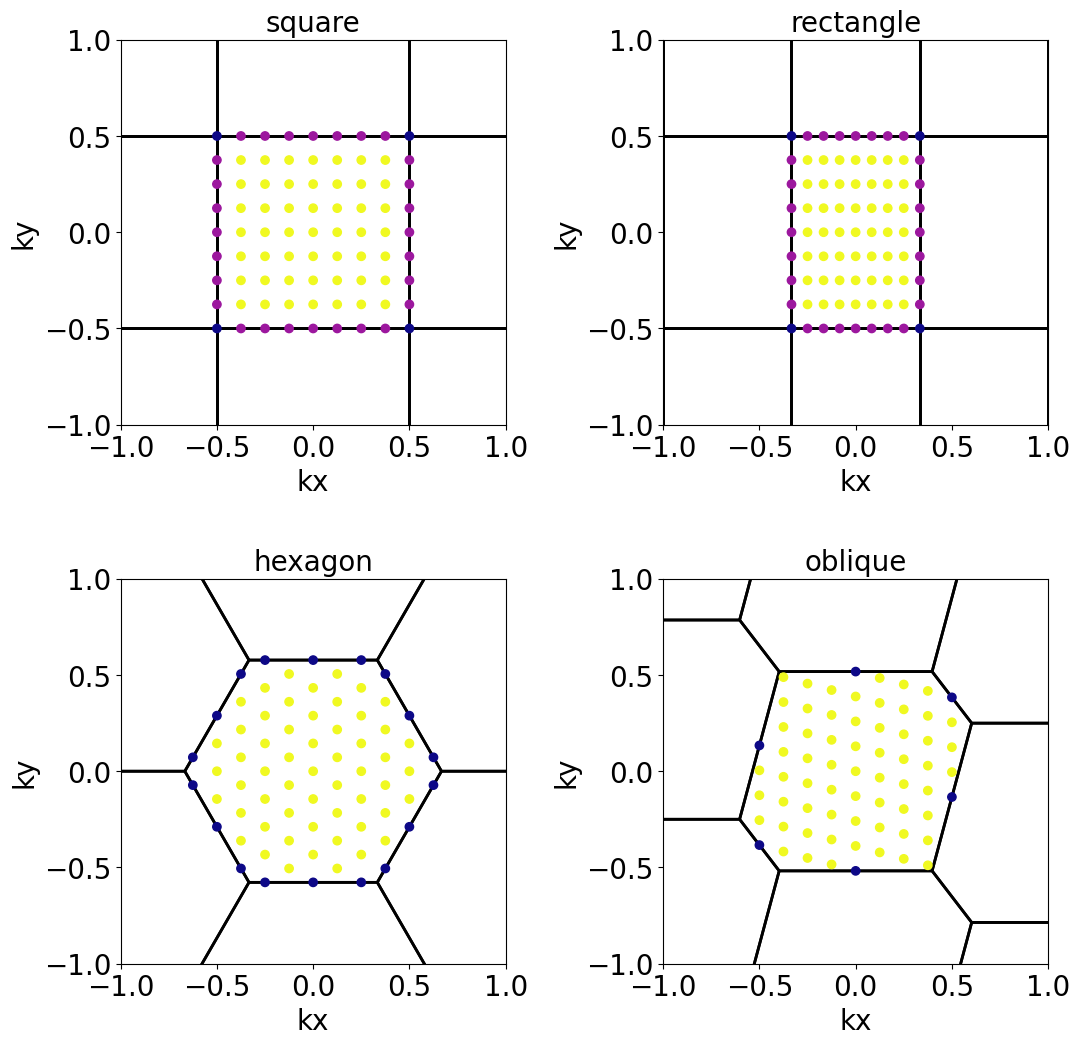

In [89]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    #print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    #print("lattice lengths: [{} {}]".format(rlat.vectors.length1, rlat.vectors.length2))
    canvas.plot_tesselation(rlat)    
    constraint = {'type':'n_points', 'value':5}
    sampling, weighting, int_element = rlat.unit_cell.sample(use_symmetry=False,
                                                            constraint=constraint)
    #print(sampling)
    #print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    #print(np.sum(weighting))
    #print(weighting)
    canvas.plot_point_sampling_weighted(sampling, weighting)
    full_area = rlat.unit_cell.area()
    weight_sum = np.sum(int_element*weighting)
    print("integration value check: {}".format(weight_sum/full_area))
    #print("simple check: {}".format(full_area/int_element))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

## Weighted Sampling of the IBZ

square
integration element: 0.015625
unique weighting: [0.125 0.25  0.5   1.   ]
integration value check: 1.0
rectangle
integration element: 0.015625
unique weighting: [0.25 0.5  1.  ]
integration value check: 1.0
hexagon
integration element: 0.015625
unique weighting: [0.08333333 0.25       0.5        1.        ]
integration value check: 1.0
oblique
integration element: 0.015625
unique weighting: [0.5 1. ]
integration value check: 1.0


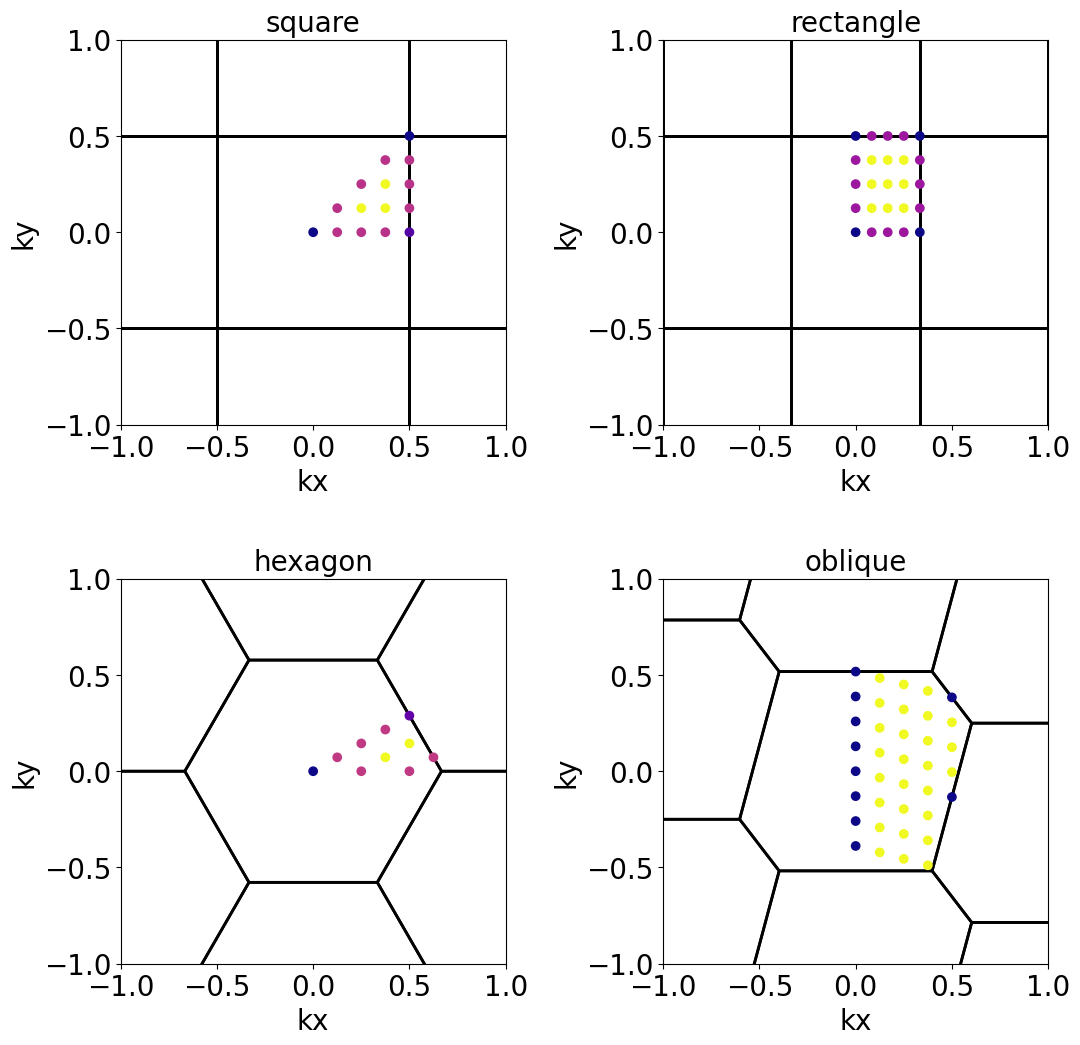

In [5]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)    
    sampling, weighting, int_element, sym_ops = rlat.unit_cell.sample_irreducible()
    
    print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    canvas.plot_point_sampling_weighted(sampling, weighting)
    full_area = rlat.unit_cell.area()
    weight_sum = np.sum(int_element*weighting)
    symmetry_multiplier = rlat.unit_cell.symmetry().get_n_symmetry_ops()
    print("integration value check: {}".format(symmetry_multiplier*weight_sum))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

## BZ Sampling from symmetry

unique weighting: [0.00510204]
integration value check: 1.1122448979591835
unique weighting: [0.00510204]
integration value check: 1.1122448979591835
unique weighting: [0.00510204]
integration value check: 1.0612244897959182
unique weighting: [0.00510204]
integration value check: 1.0255102040816324


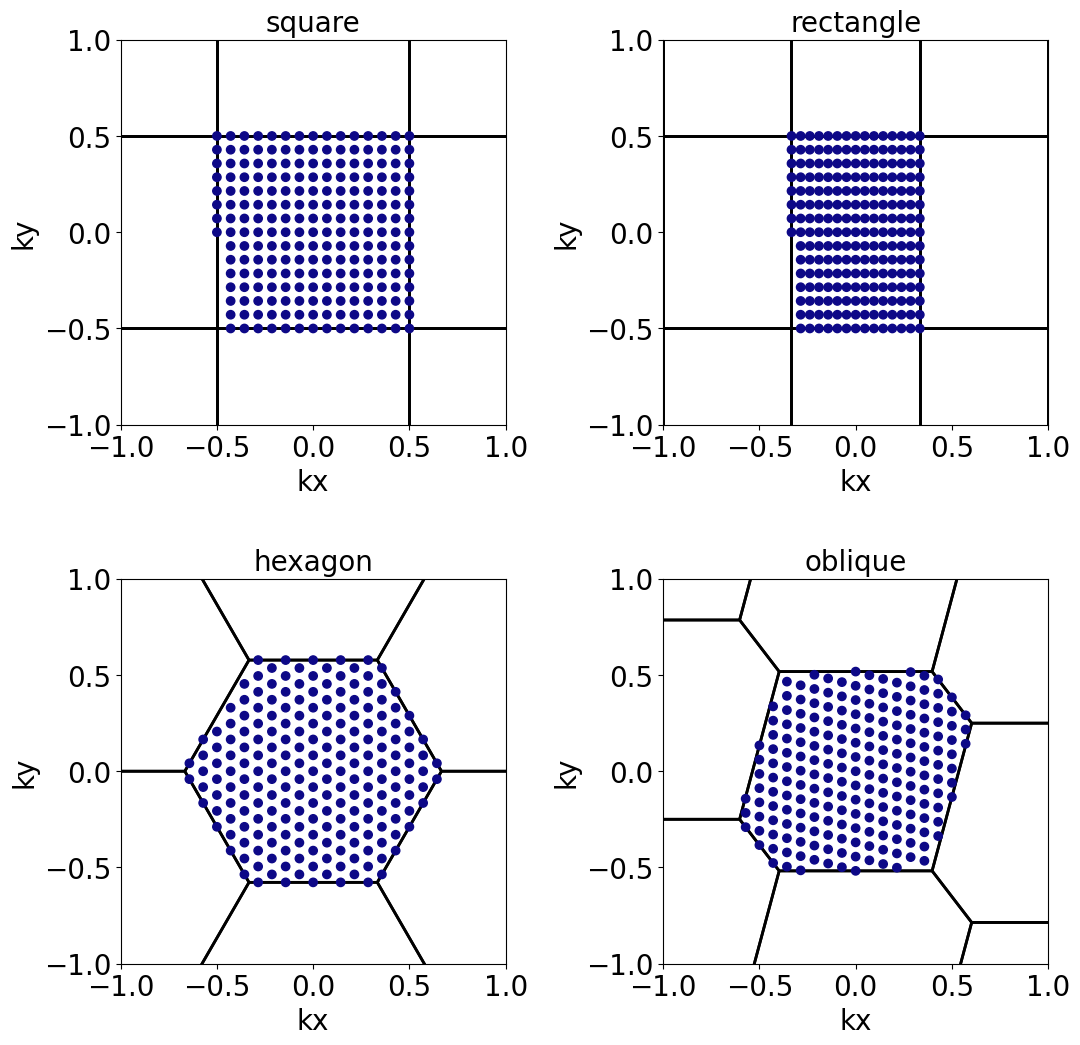

In [30]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    #print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    #print("lattice lengths: [{} {}]".format(rlat.vectors.length1, rlat.vectors.length2))
    canvas.plot_tesselation(rlat)    
    constraint = {'type':'n_points', 'value':8}
    sampling, weighting, int_element = rlat.unit_cell.sample(use_symmetry=True,
                                                            constraint=constraint)
    #print(sampling)
    #print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    #print(np.sum(weighting))
    canvas.plot_point_sampling_weighted(sampling, weighting)
    #full_area = rlat.unit_cell.area()
    weight_sum = np.sum(weighting)
    print("integration value check: {}".format(weight_sum))
    #print("simple check: {}".format(full_area/int_element))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

## Symmetry based excluding duplicates

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    #print(lat_shape)
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    #print("lattice lengths: [{} {}]".format(rlat.vectors.length1, rlat.vectors.length2))
    canvas.plot_tesselation(rlat)    
    constraint = {'type':'n_points', 'value':8}
    sampling, weighting, int_element = rlat.unit_cell.sample(use_symmetry=True,
                                                            constraint=constraint)
    #print(sampling)
    #print("integration element: {}".format(int_element))
    print("unique weighting: {}".format(np.unique(weighting)))
    #print(np.sum(weighting))
    canvas.plot_point_sampling_weighted(sampling, weighting)
    full_area = rlat.unit_cell.area()
    weight_sum = np.sum(int_element*weighting)
    print("integration value check: {}".format(weight_sum))
    #print("simple check: {}".format(full_area/int_element))
    plt.xlabel('kx')
    plt.ylabel('ky')
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    plt.title(lat_shape, fontsize=20)

# Kspace
## 

[5, 5]
[-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6] [-7 -6 -5 -4 -3 -2 -1  0  1  2  3  4  5  6]
[ 7.85398163e-01 -4.80917673e-17  0.00000000e+00] [0.         0.78539816 0.        ]
{<SpecialPoint.GAMMA: 1>: [array([0., 0., 0.])], <SpecialPoint.X: 4>: [array([ 3.14159265e+00, -1.92367069e-16,  0.00000000e+00])], <SpecialPoint.M: 3>: [array([3.14159265, 3.14159265, 0.        ])], <SpecialPoint.AXIS: 12>: [array([ 7.85398163e-01, -4.80917673e-17,  0.00000000e+00]), array([0.78539816, 0.78539816, 0.        ]), array([ 1.57079633e+00, -9.61835347e-17,  0.00000000e+00]), array([1.57079633, 1.57079633, 0.        ]), array([ 2.35619449e+00, -1.44275302e-16,  0.00000000e+00]), array([2.35619449, 2.35619449, 0.        ]), array([3.14159265, 0.78539816, 0.        ]), array([3.14159265, 1.57079633, 0.        ]), array([3.14159265, 2.35619449, 0.        ])], <SpecialPoint.INTERIOR: 13>: [array([1.57079633, 0.78539816, 0.        ]), array([2.35619449, 0.78539816, 0.        ]), array([2.35619449, 1.57

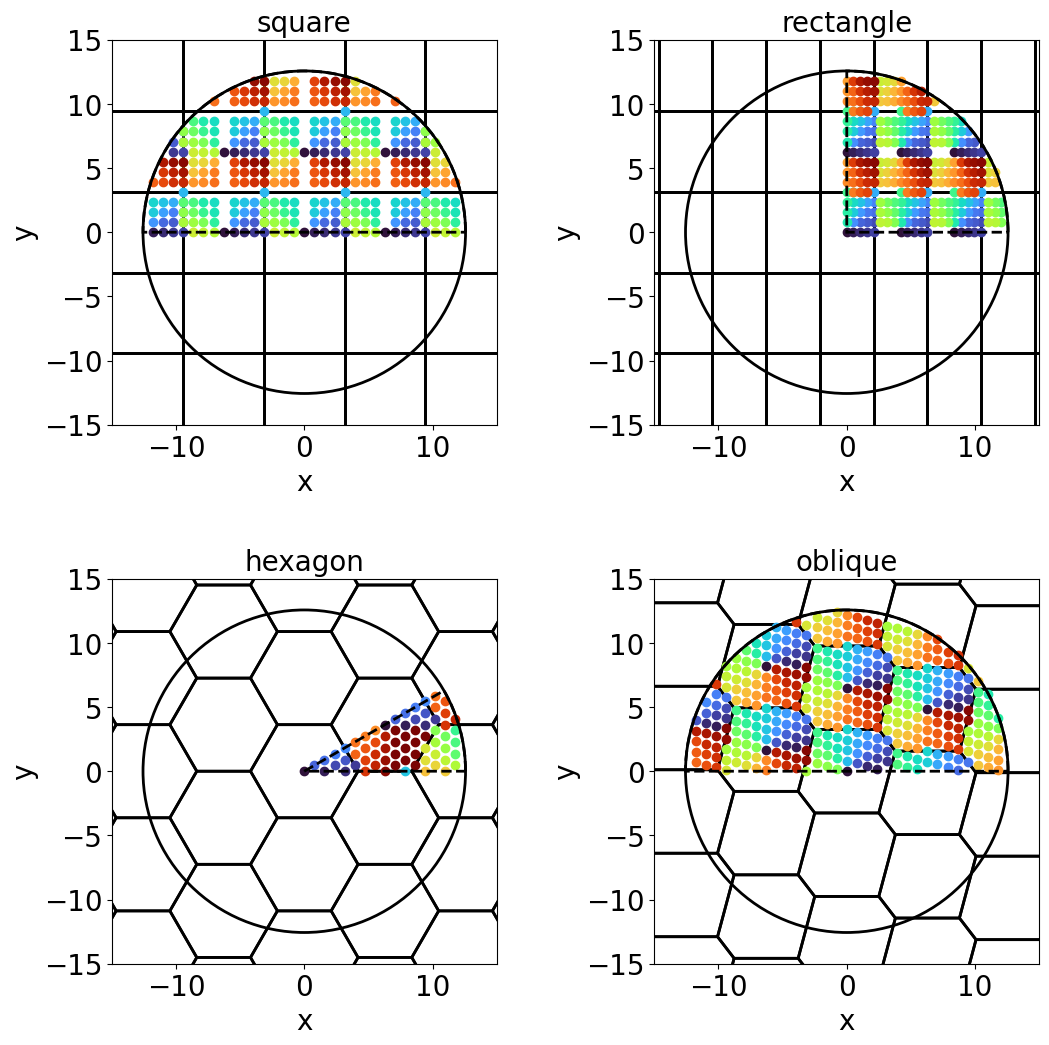

In [4]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    families = kspace.periodic_sampler.sample_bloch_families(restrict_to_sym_cone=True)
    canvas.plot_bloch_families(families)
    canvas.plot_symmetry_cone(kspace)
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

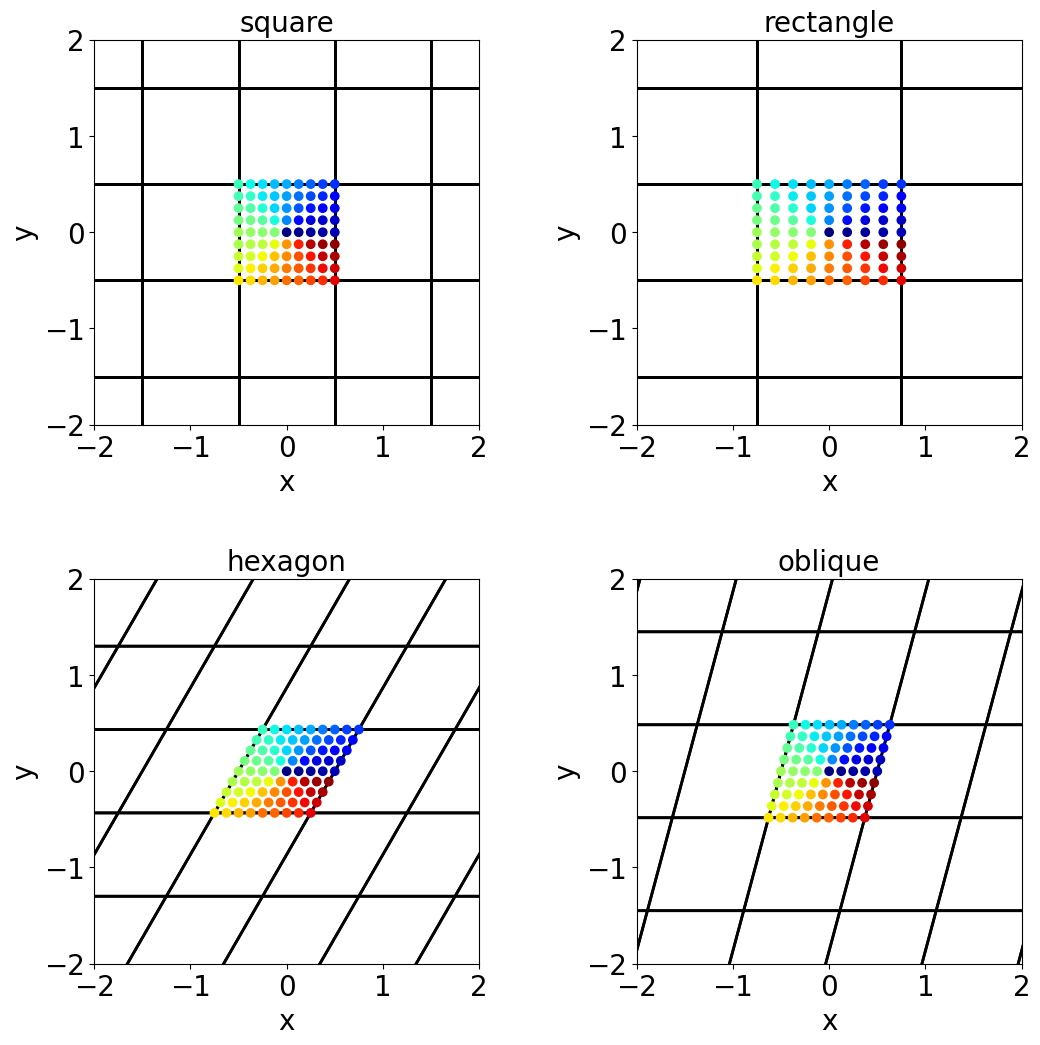

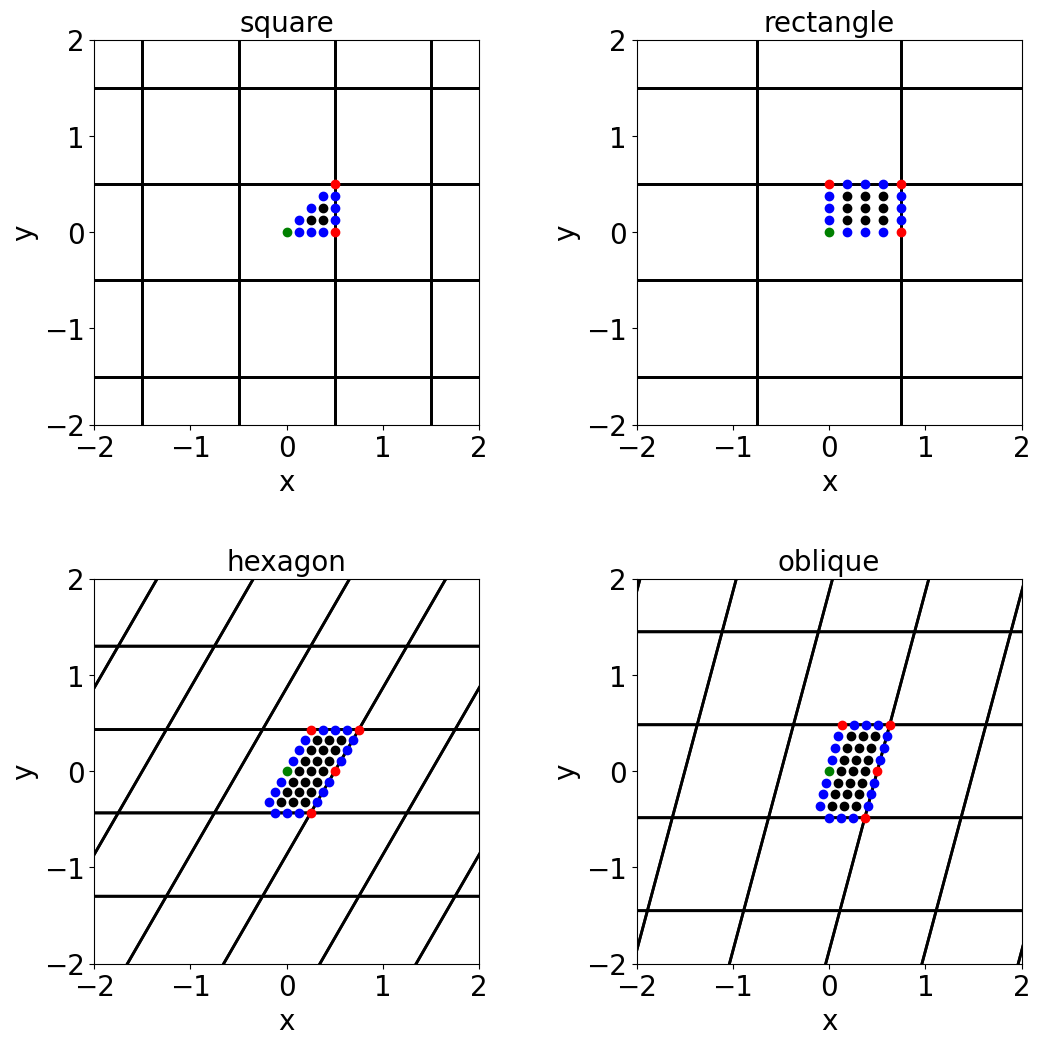

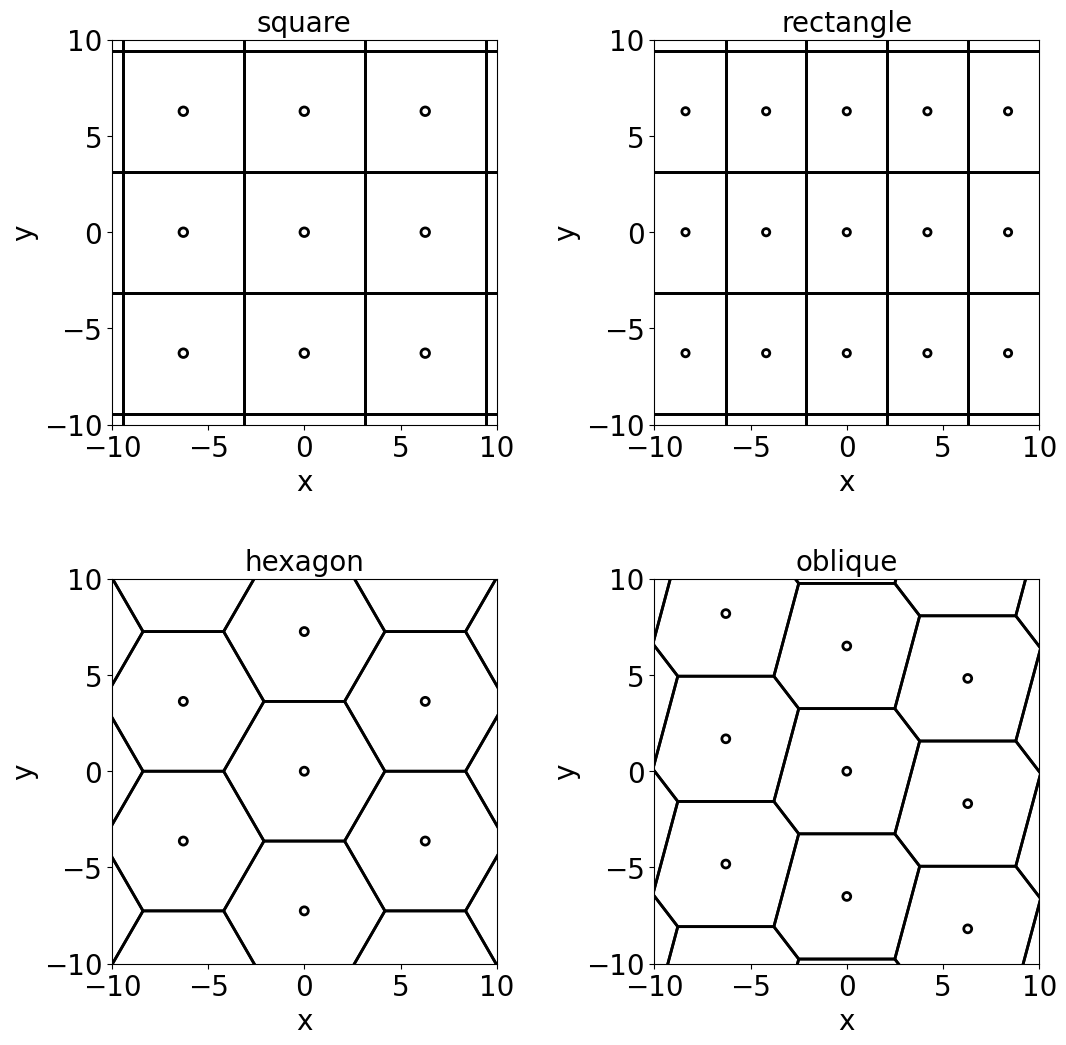

In [8]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)
    canvas.plot_lattice(rlat)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

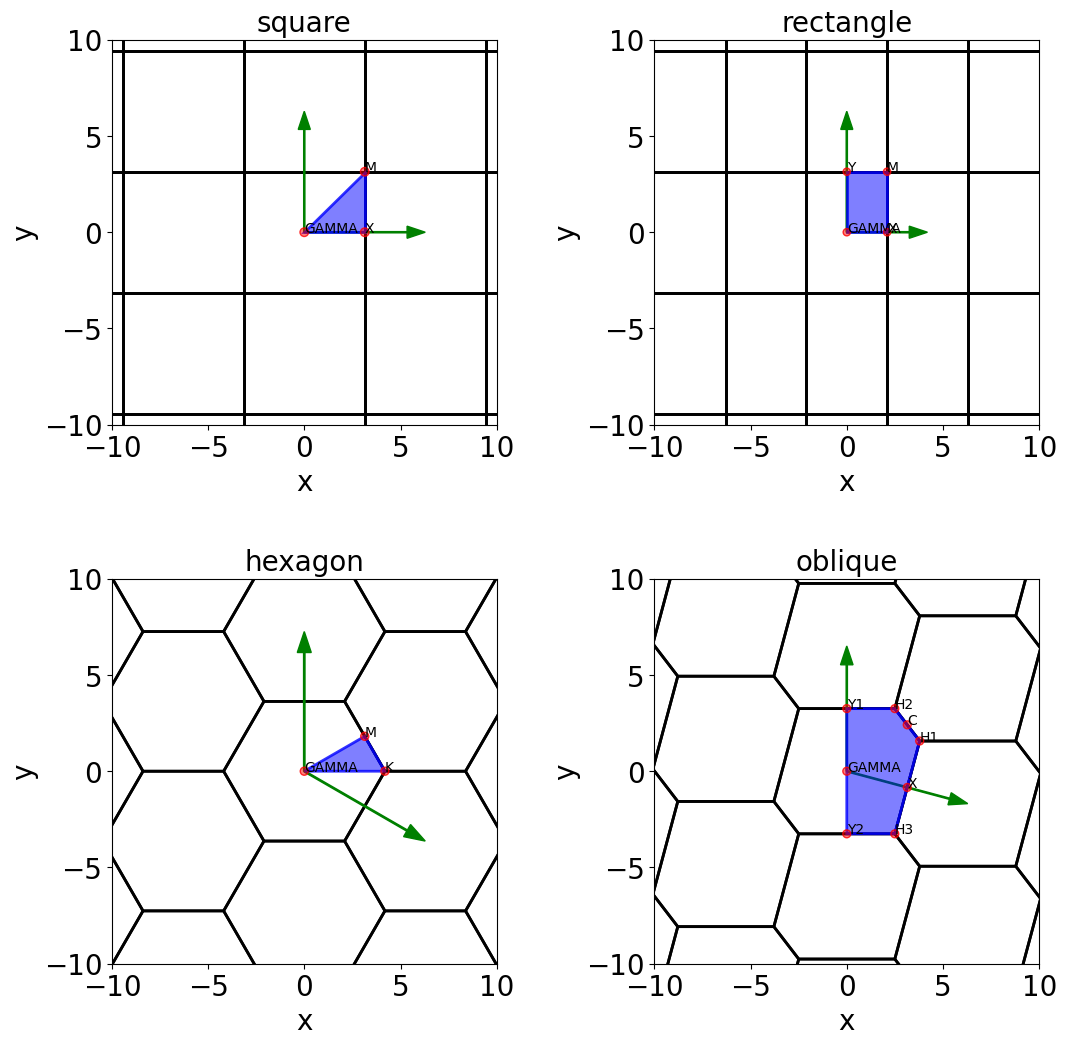

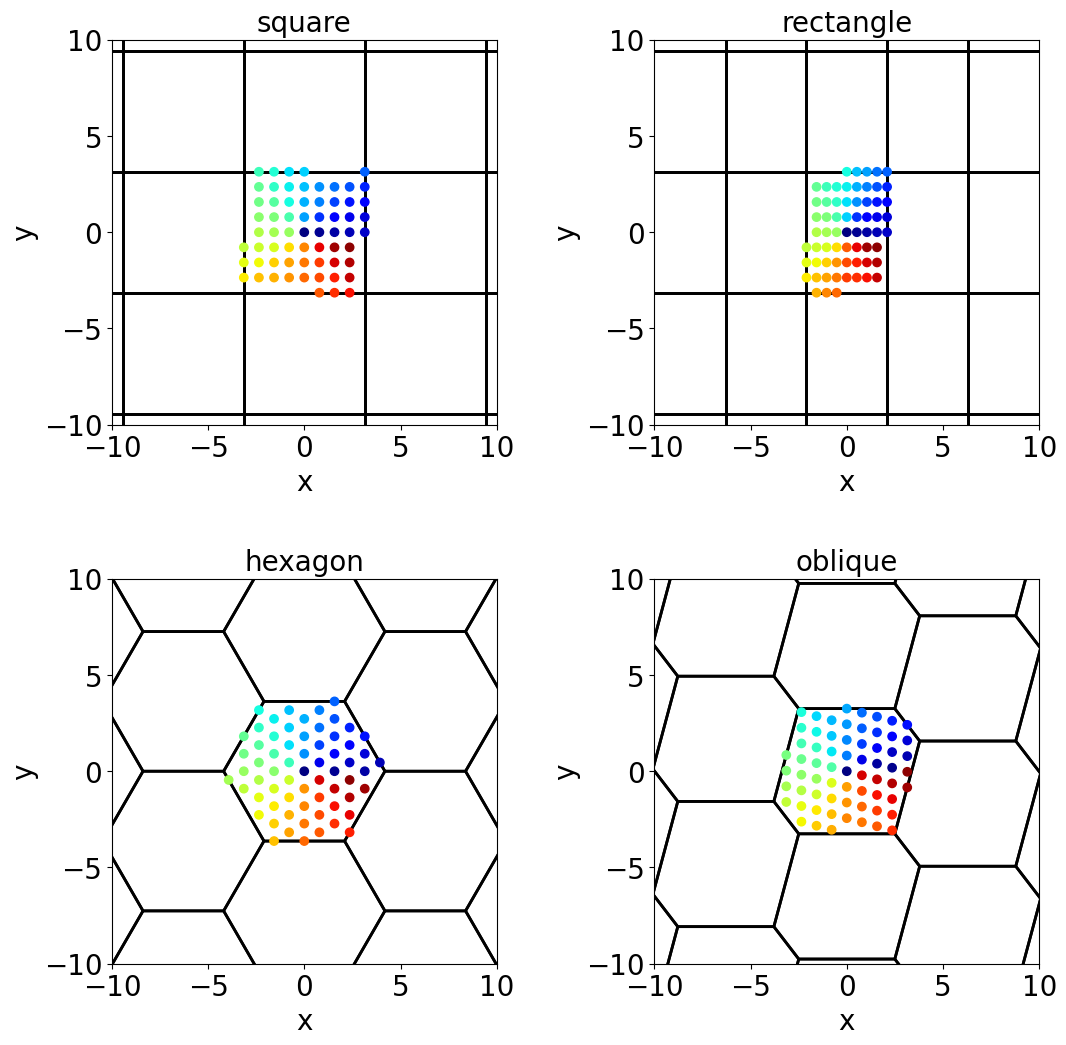

In [10]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    canvas.plot_tesselation(rlat)        
    sample = rlat.unit_cell.sample()
    canvas.plot_sampling(sample)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-10, 10])
    plt.ylim([-10, 10])
    plt.title(lat_shape, fontsize=20)

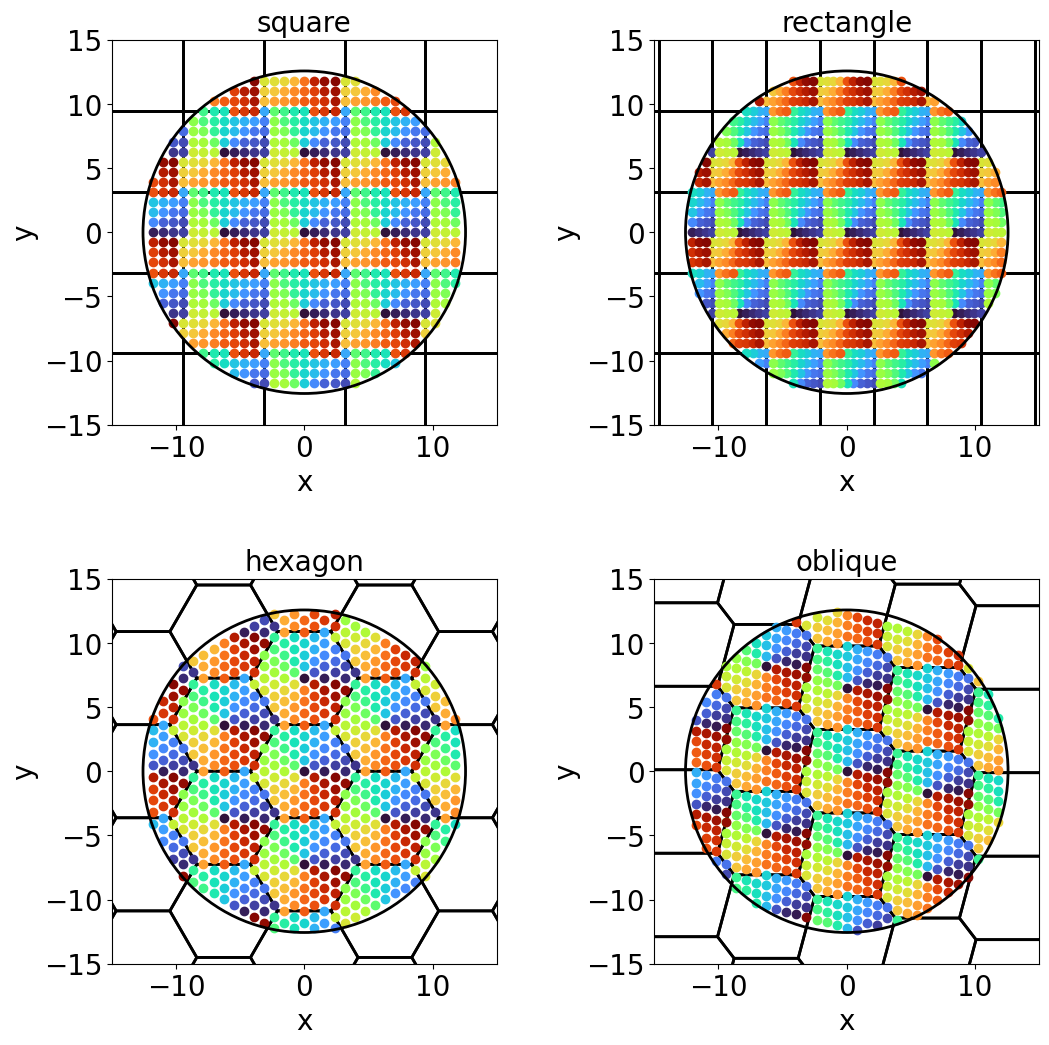

In [11]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    families = kspace.periodic_sampler.sample_bloch_families()
    canvas.plot_bloch_families(families)
      
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

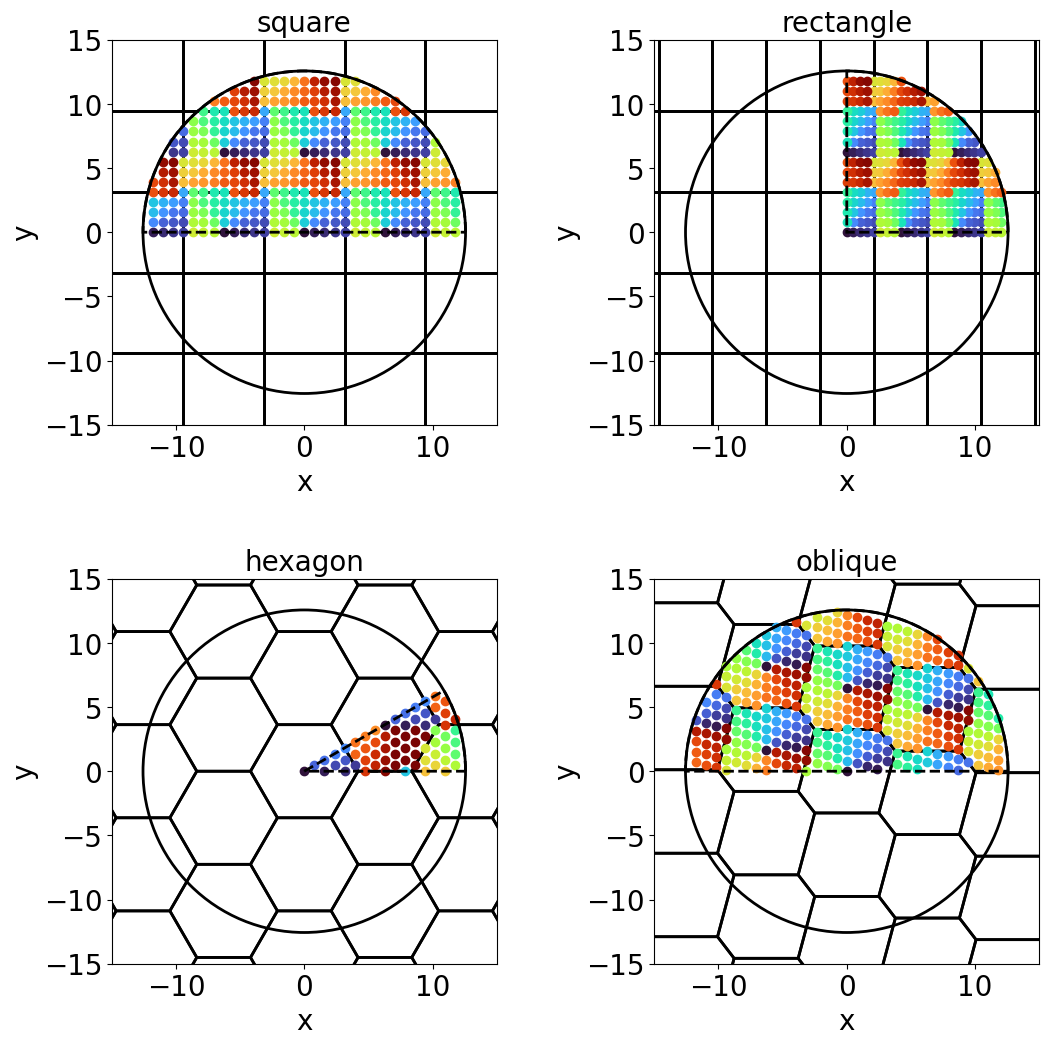

In [12]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    families = kspace.periodic_sampler.sample_bloch_families(restrict_to_sym_cone=True)
    canvas.plot_bloch_families(families)
    canvas.plot_symmetry_cone(kspace)
    
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

IndexError: list index out of range

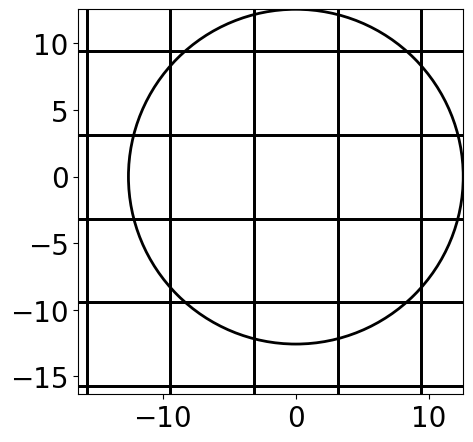

In [13]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 0.5
    k0 = 2*np.pi/wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)
    canvas.plot_fermi_circle(kspace)
    sampling = kspace.periodic_sampler.sample(restrict_to_sym_cone=True, constraint={'type':'n_points', 'value':4})
    #canvas.plot_sampling(sampling.k,  color='k')
    groups = kspace.symmetrise_sample(sampling)
    canvas.plot_symmetry_cone(kspace)    
    
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(groups)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)
        canvas.plot_point_sampling(groups[i], plot_n_points='all', color = color)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

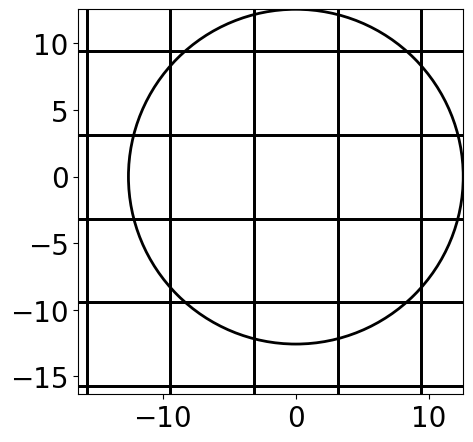

In [14]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)

    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(2, n_refinements = 4)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)

    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4, restrict_to_sym_cone=True)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)
    canvas.plot_symmetry_cone(kspace)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)

In [ ]:
fig = plt.figure(figsize=(12,12))
gs = gridspec.GridSpec(2, 2, fig, wspace=0.4, hspace=0.4)

for ilat, lat_shape in enumerate(['square', 'rectangle', 'hexagon', 'oblique']):
    index =  np.unravel_index(ilat, (2,2))
    ax = fig.add_subplot(gs[index])    
    canvas = Canvas(ax=ax)
    wvl = 2.0
    k0 = 2*np.pi*wvl
    kspace = KSpace(wvl, symmetry=get_symmetry(lat_shape), fermi_radius=k0)
    lat_vec = get_lattice_vectors(lat_shape)
    lat = Lattice(lat_vec)
    rlat = lat.make_reciprocal()
    kspace.apply_lattice(rlat)
    canvas.plot_tesselation(rlat)            
    canvas.plot_fermi_circle(kspace)
    woods1 = kspace.periodic_sampler.calc_woods_anomalies(1, n_refinements = 4, restrict_to_sym_cone=True)
    cmap = cm.get_cmap('tab20')
    NColors = 20
    for i in range(len(woods1)):
        color = np.zeros((1,4))
        color[0,:] = cmap((float(i))/NColors)    
        #canvas.plot_point_sampling(woods1[i], plot_n_points='all', color =color)
        sym_woods = kspace.symmetrise_sample(woods1[i])
        for i_wood in range(len(sym_woods)):
            canvas.plot_point_sampling(sym_woods[i_wood], color=color)
        
    canvas.plot_symmetry_cone(kspace)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.title(lat_shape, fontsize=20)